# # 방법 1
---

## # 2D
---

In [ ]:
!git clone https://github.com/Bharath2/Informed-RRT-star
%cd /content/Informed-RRT-star
# %pip install -qr requirements.txt
!pip install rtree

Cloning into 'Informed-RRT-star'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 96 (delta 36), reused 53 (delta 17), pack-reused 0
Unpacking objects: 100% (96/96), done.
/content/Informed-RRT-star
     |████████████████████████████████| 1.0 MB 12.9 MB/s 


In [ ]:
# 모듈 경로 추가하는 법

import sys
sys.path.append("/content/Informed-RRT-star")

In [ ]:
import numpy as np
from PathPlanning import RRT, RRTStar, Map
import matplotlib.pyplot as plt

np.random.seed(1)

In [ ]:
#2D example
#list of obstacles
obstacles = [[-5,25,20,35],
             [30,25,55,35],
             [45,35,55,60],
             [45,70,55,80],
             [-5,65,30,70],
             [70,40,80,70],]

#initialise environment map
bounds = np.array([0,100])
mapobs = Map(obstacles,bounds,dim = 2)

In [ ]:
#initialise RRT
rrt = RRT(start=np.array([80,20]),
          goal= np.array([20,50]),
          Map = mapobs, max_iter=10000)

path not available


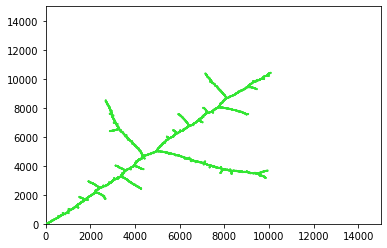

In [ ]:
#plan path
path = rrt.plan()

#plot the map, path 
def draw_map(rrt,path):
    fig = plt.figure()
    ax = plt.axes()
    ax.axis([bounds[0]-0.5, bounds[1]+0.5, bounds[0]-0.5, bounds[1]+0.5])

    rrt.draw_graph(ax)
    rrt.draw_path(ax,path)
    rrt.map.plotobs(ax)
    plt.show()
    
draw_map(rrt,path)
path

In [ ]:
obstacles = [
             [-5,25,20,35],
             [30,25,55,35],
             [45,35,55,60],
             [45,70,55,80],
             [-5,65,30,70],
             [70,40,80,70],]

bounds = np.array([0,100])
mapobs = Map(obstacles,bounds,dim = 2)

In [ ]:
#initialise Informed RRT*
rrt = RRTStar(start=np.array([80,20]),
              goal= np.array([20,80]),
              Map = mapobs, max_iter = 500,
              goal_sample_rate = 0.8,
              max_extend_length = 10,
              path_resolution = 1)

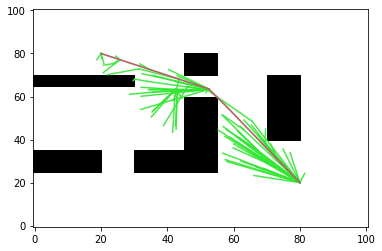

array([[80.        , 20.        ],
       [57.97234831, 55.18386902],
       [52.49247474, 63.54873517],
       [43.57083443, 68.06585086],
       [34.64919412, 72.58296655],
       [25.72755381, 77.10008224],
       [20.        , 80.        ]])

In [ ]:
path, cost = rrt.plan()

#plot path 
draw_map(rrt,path)

path

## # 3D
---

In [ ]:
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    

In [ ]:
# 3D boxes   lx, ly, lz, hx, hy, hz
obstacles = [[-5, 25, 0, 20, 35, 60],
             [30, 25, 0, 55, 35, 100],
             [45, 35, 0, 55, 60, 60],
             [45, 75, 0, 55, 85, 100],
             [-5, 65, 0, 30, 70, 100],
             [70, 50, 0, 80, 80, 100]]

# limits on map dimensions
bounds = np.array([0,100])
# create map with obstacles
mapobs = Map(obstacles, bounds, dim = 3)

#plan a path from start to goal
start = np.array([90,60,60])
goal = np.array([20,40,20])

rrt = RRTStar(start = start, goal = goal,
              Map = mapobs, max_iter = 500,
              goal_sample_rate = 0.1)

waypoints, min_cost = rrt.plan()

#plot the waypoints and obstacles
# rrt.draw_scene(waypoints, ax)

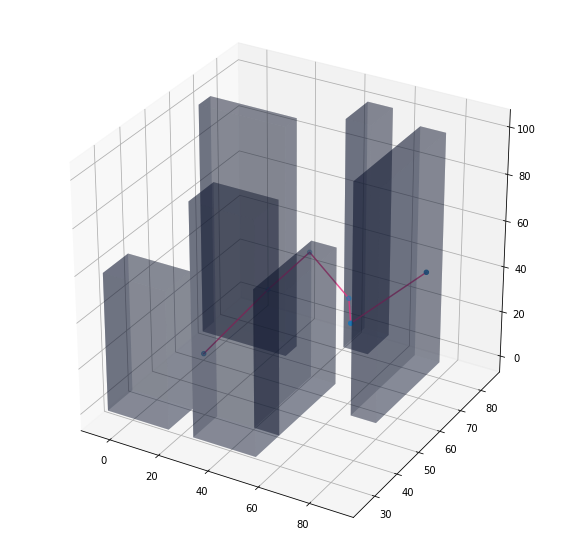

In [ ]:
plt.figure(figsize = (10, 10))
ax = plt.subplot(1, 1, 1, projection = '3d')
# ax.view_init(-45, 90)
rrt.draw_scene(waypoints, ax)

# 방법 2 (사용 안함)
---

In [ ]:
import copy
import math
import random

import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
import numpy as np

show_animation = True


class InformedRRTStar:

    def __init__(self, start, goal,
                 obstacleList, randArea,
                 expandDis=0.5, goalSampleRate=10, maxIter=200):

        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.min_rand = randArea[0]
        self.max_rand = randArea[1]
        self.expand_dis = expandDis
        self.goal_sample_rate = goalSampleRate
        self.max_iter = maxIter
        self.obstacle_list = obstacleList
        self.node_list = None

    def informed_rrt_star_search(self, animation=True):

        self.node_list = [self.start]
        # max length we expect to find in our 'informed' sample space,
        # starts as infinite
        cBest = float('inf')
        solutionSet = set()
        path = None

        # Computing the sampling space
        cMin = math.sqrt(pow(self.start.x - self.goal.x, 2)
                         + pow(self.start.y - self.goal.y, 2))
        xCenter = np.array([[(self.start.x + self.goal.x) / 2.0],
                            [(self.start.y + self.goal.y) / 2.0], [0]])
        a1 = np.array([[(self.goal.x - self.start.x) / cMin],
                       [(self.goal.y - self.start.y) / cMin], [0]])

        e_theta = math.atan2(a1[1], a1[0])
        # first column of identity matrix transposed
        id1_t = np.array([1.0, 0.0, 0.0]).reshape(1, 3)
        M = a1 @ id1_t
        U, S, Vh = np.linalg.svd(M, True, True)
        C = np.dot(np.dot(U, np.diag(
            [1.0, 1.0, np.linalg.det(U) * np.linalg.det(np.transpose(Vh))])),
                   Vh)

        for i in range(self.max_iter):
            # Sample space is defined by cBest
            # cMin is the minimum distance between the start point and the goal
            # xCenter is the midpoint between the start and the goal
            # cBest changes when a new path is found

            rnd = self.informed_sample(cBest, cMin, xCenter, C)
            n_ind = self.get_nearest_list_index(self.node_list, rnd)
            nearestNode = self.node_list[n_ind]
            # steer
            theta = math.atan2(rnd[1] - nearestNode.y, rnd[0] - nearestNode.x)
            newNode = self.get_new_node(theta, n_ind, nearestNode)
            d = self.line_cost(nearestNode, newNode)

            noCollision = self.check_collision(nearestNode, theta, d)

            if noCollision:
                nearInds = self.find_near_nodes(newNode)
                newNode = self.choose_parent(newNode, nearInds)

                self.node_list.append(newNode)
                self.rewire(newNode, nearInds)

                if self.is_near_goal(newNode):
                    if self.check_segment_collision(newNode.x, newNode.y,
                                                    self.goal.x, self.goal.y):
                        solutionSet.add(newNode)
                        lastIndex = len(self.node_list) - 1
                        tempPath = self.get_final_course(lastIndex)
                        tempPathLen = self.get_path_len(tempPath)
                        if tempPathLen < cBest:
                            path = tempPath
                            cBest = tempPathLen
            if animation:
                self.draw_graph(xCenter=xCenter,
                                cBest=cBest, cMin=cMin,
                                e_theta=e_theta, rnd=rnd)

        return path

    def choose_parent(self, newNode, nearInds):
        if len(nearInds) == 0:
            return newNode

        dList = []
        for i in nearInds:
            dx = newNode.x - self.node_list[i].x
            dy = newNode.y - self.node_list[i].y
            d = math.hypot(dx, dy)
            theta = math.atan2(dy, dx)
            if self.check_collision(self.node_list[i], theta, d):
                dList.append(self.node_list[i].cost + d)
            else:
                dList.append(float('inf'))

        minCost = min(dList)
        minInd = nearInds[dList.index(minCost)]

        if minCost == float('inf'):
            print("min cost is inf")
            return newNode

        newNode.cost = minCost
        newNode.parent = minInd

        return newNode

    def find_near_nodes(self, newNode):
        n_node = len(self.node_list)
        r = 50.0 * math.sqrt((math.log(n_node) / n_node))
        d_list = [(node.x - newNode.x) ** 2 + (node.y - newNode.y) ** 2
                  for node in self.node_list]
        near_inds = [d_list.index(i) for i in d_list if i <= r ** 2]
        return near_inds

    def informed_sample(self, cMax, cMin, xCenter, C):
        if cMax < float('inf'):
            r = [cMax / 2.0,
                 math.sqrt(cMax ** 2 - cMin ** 2) / 2.0,
                 math.sqrt(cMax ** 2 - cMin ** 2) / 2.0]
            L = np.diag(r)
            xBall = self.sample_unit_ball()
            rnd = np.dot(np.dot(C, L), xBall) + xCenter
            rnd = [rnd[(0, 0)], rnd[(1, 0)]]
        else:
            rnd = self.sample_free_space()

        return rnd

    @staticmethod
    def sample_unit_ball():
        a = random.random()
        b = random.random()

        if b < a:
            a, b = b, a

        sample = (b * math.cos(2 * math.pi * a / b),
                  b * math.sin(2 * math.pi * a / b))
        return np.array([[sample[0]], [sample[1]], [0]])

    def sample_free_space(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = [random.uniform(self.min_rand, self.max_rand),
                   random.uniform(self.min_rand, self.max_rand)]
        else:
            rnd = [self.goal.x, self.goal.y]

        return rnd

    @staticmethod
    def get_path_len(path):
        pathLen = 0
        for i in range(1, len(path)):
            node1_x = path[i][0]
            node1_y = path[i][1]
            node2_x = path[i - 1][0]
            node2_y = path[i - 1][1]
            pathLen += math.sqrt((node1_x - node2_x)
                                 ** 2 + (node1_y - node2_y) ** 2)

        return pathLen

    @staticmethod
    def line_cost(node1, node2):
        return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)

    @staticmethod
    def get_nearest_list_index(nodes, rnd):
        dList = [(node.x - rnd[0]) ** 2
                 + (node.y - rnd[1]) ** 2 for node in nodes]
        minIndex = dList.index(min(dList))
        return minIndex

    def get_new_node(self, theta, n_ind, nearestNode):
        newNode = copy.deepcopy(nearestNode)

        newNode.x += self.expand_dis * math.cos(theta)
        newNode.y += self.expand_dis * math.sin(theta)

        newNode.cost += self.expand_dis
        newNode.parent = n_ind
        return newNode

    def is_near_goal(self, node):
        d = self.line_cost(node, self.goal)
        if d < self.expand_dis:
            return True
        return False

    def rewire(self, newNode, nearInds):
        n_node = len(self.node_list)
        for i in nearInds:
            nearNode = self.node_list[i]

            d = math.sqrt((nearNode.x - newNode.x) ** 2
                          + (nearNode.y - newNode.y) ** 2)

            s_cost = newNode.cost + d

            if nearNode.cost > s_cost:
                theta = math.atan2(newNode.y - nearNode.y,
                                   newNode.x - nearNode.x)
                if self.check_collision(nearNode, theta, d):
                    nearNode.parent = n_node - 1
                    nearNode.cost = s_cost

    @staticmethod
    def distance_squared_point_to_segment(v, w, p):
        # Return minimum distance between line segment vw and point p
        if np.array_equal(v, w):
            return (p - v).dot(p - v)  # v == w case
        l2 = (w - v).dot(w - v)  # i.e. |w-v|^2 -  avoid a sqrt
        # Consider the line extending the segment,
        # parameterized as v + t (w - v).
        # We find projection of point p onto the line.
        # It falls where t = [(p-v) . (w-v)] / |w-v|^2
        # We clamp t from [0,1] to handle points outside the segment vw.
        t = max(0, min(1, (p - v).dot(w - v) / l2))
        projection = v + t * (w - v)  # Projection falls on the segment
        return (p - projection).dot(p - projection)

    def check_segment_collision(self, x1, y1, x2, y2):
        for (ox, oy, size) in self.obstacle_list:
            dd = self.distance_squared_point_to_segment(
                np.array([x1, y1]),
                np.array([x2, y2]),
                np.array([ox, oy]))
            if dd <= size ** 2:
                return False  # collision
        return True

    def check_collision(self, nearNode, theta, d):
        tmpNode = copy.deepcopy(nearNode)
        end_x = tmpNode.x + math.cos(theta) * d
        end_y = tmpNode.y + math.sin(theta) * d
        return self.check_segment_collision(tmpNode.x, tmpNode.y, end_x, end_y)

    def get_final_course(self, lastIndex):
        path = [[self.goal.x, self.goal.y]]
        while self.node_list[lastIndex].parent is not None:
            node = self.node_list[lastIndex]
            path.append([node.x, node.y])
            lastIndex = node.parent
        path.append([self.start.x, self.start.y])
        return path

    def draw_graph(self, xCenter=None, cBest=None, cMin=None, e_theta=None,
                   rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd[0], rnd[1], "^k")
            if cBest != float('inf'):
                self.plot_ellipse(xCenter, cBest, cMin, e_theta)

        for node in self.node_list:
            if node.parent is not None:
                if node.x or node.y is not None:
                    plt.plot([node.x, self.node_list[node.parent].x], [
                        node.y, self.node_list[node.parent].y], "-g")

        for (ox, oy, size) in self.obstacle_list:
            plt.plot(ox, oy, "ok", ms=30 * size)

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.goal.x, self.goal.y, "xr")
        plt.axis([-2, 15, -2, 15])
        plt.grid(True)
        plt.pause(0.01)

    @staticmethod
    def plot_ellipse(xCenter, cBest, cMin, e_theta):  # pragma: no cover

        a = math.sqrt(cBest ** 2 - cMin ** 2) / 2.0
        b = cBest / 2.0
        angle = math.pi / 2.0 - e_theta
        cx = xCenter[0]
        cy = xCenter[1]
        t = np.arange(0, 2 * math.pi + 0.1, 0.1)
        x = [a * math.cos(it) for it in t]
        y = [b * math.sin(it) for it in t]
        rot = Rot.from_euler('z', -angle).as_matrix()[0:2, 0:2]
        fx = rot @ np.array([x, y])
        px = np.array(fx[0, :] + cx).flatten()
        py = np.array(fx[1, :] + cy).flatten()
        plt.plot(cx, cy, "xc")
        plt.plot(px, py, "--c")


class Node:

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.cost = 0.0
        self.parent = None


def main():
    print("Start informed rrt star planning")

    # create obstacles
    obstacleList = [
        (5, 5, 0.5),
        (9, 6, 1),
        (7, 5, 1),
        (1, 5, 1),
        (3, 6, 1),
        (7, 9, 1)
    ]

    # Set params
    rrt = InformedRRTStar(start=[0, 0], goal=[5, 10],
                          randArea=[-2, 15], obstacleList=obstacleList)
    path = rrt.informed_rrt_star_search(animation=show_animation)
    print("Done!!")

    # Plot path
    if show_animation:
        rrt.draw_graph()
        plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
        plt.grid(True)
        plt.pause(0.01)
        plt.show()


if __name__ == '__main__':
    main()

Output hidden; open in https://colab.research.google.com to view.

# # 실제 좌표로 최단거리 구하기
---

In [ ]:
new_a = a.replace('POLYGON ((','').replace('))','').replace(',','').split(' ')
lat = []
lon = []
for i in range(len(new_a)):
    if i % 2 == 0:
        lat.append(float(new_a[i]))
    else:
        lon.append(float(new_a[i]))
obstacles = [[min(lat),min(lon)],[max(lat),max(lon)]]
obstacles

obstacle_1 = []
for i in obstacles:
    for j in mapToGrid(i):
        obstacle_1.append(j)
obstacle_1

[305243, 623883, 305269, 623915]

In [ ]:
# start, goal
start = [127.108238, 37.526564]
goal = [127.105915, 37.506078]

mapToGrid(start), mapToGrid(goal)

((305294, 624356), (305125, 622132))

In [ ]:
#2D example
#list of obstacles
obstacles = [obstacle_1,]

#initialise environment map
bounds = np.array([300000, 625000])
mapobs = Map(obstacles, bounds, dim = 2)

path not available


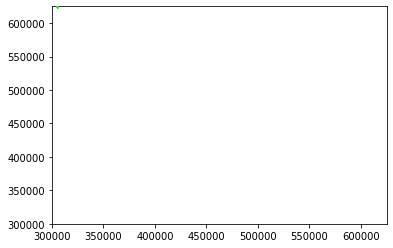

In [ ]:
#initialise Informed RRT*
rrt = RRTStar(start=np.array(mapToGrid(start)),
              goal= np.array(mapToGrid(goal)),
              Map = mapobs, max_iter= 100,
              goal_sample_rate = 0.1)

#plan path
path, cost = rrt.plan()

#plot path 
draw_map(rrt,path)

path

# # 위도, 경도 <-> X, Y 좌표 변환 사용자 함수
---

In [ ]:
import math
NX = 149            ## X축 격자점 수
NY = 253            ## Y축 격자점 수

Re = 6371.00877     ##  지도반경
grid = 0.001         ##  격자간격 (km)
slat1 = 30.0        ##  표준위도 1
slat2 = 60.0        ##  표준위도 2
olon = 126.0        ##  기준점 경도
olat = 38.0         ##  기준점 위도
xo = 210 / grid     ##  기준점 X좌표
yo = 675 / grid     ##  기준점 Y좌표
# xo = 43 
# yo = 136
first = 0

if first == 0 :
    PI = math.asin(1.0) * 2.0
    DEGRAD = PI/ 180.0
    RADDEG = 180.0 / PI

    re = Re / grid
    slat1 = slat1 * DEGRAD
    slat2 = slat2 * DEGRAD
    olon = olon * DEGRAD
    olat = olat * DEGRAD

    sn = math.tan(PI * 0.25 + slat2 * 0.5) / math.tan(PI * 0.25 + slat1 * 0.5)
    sn = math.log(math.cos(slat1) / math.cos(slat2)) / math.log(sn)
    sf = math.tan(PI * 0.25 + slat1 * 0.5)
    sf = math.pow(sf, sn) * math.cos(slat1) / sn
    ro = math.tan(PI * 0.25 + olat * 0.5)
    ro = re * sf / math.pow(ro, sn)
    first = 1

def mapToGrid(lat, lon, code = 0 ):
    # ln = list_[0]
    # lat = list_[1]
    ra = math.tan(PI * 0.25 + lat * DEGRAD * 0.5)
    ra = re * sf / pow(ra, sn)
    theta = lon * DEGRAD - olon
    if theta > PI :
        theta -= 2.0 * PI
    if theta < -PI :
        theta += 2.0 * PI
    theta *= sn
    x = (ra * math.sin(theta)) + xo
    y = (ro - ra * math.cos(theta)) + yo
    x = int(x + 1.5)
    y = int(y + 1.5)
    return x, y

def gridToMap(x, y, code = 1):
    x = x - 1
    y = y - 1
    xn = x - xo
    yn = ro - y + yo
    ra = math.sqrt(xn * xn + yn * yn)
    if sn < 0.0 :
        ra = -ra
    alat = math.pow((re * sf / ra), (1.0 / sn))
    alat = 2.0 * math.atan(alat) - PI * 0.5
    if math.fabs(xn) <= 0.0 :
        theta = 0.0
    else :
        if math.fabs(yn) <= 0.0 :
            theta = PI * 0.5
            if xn < 0.0 :
                theta = -theta
        else :
            theta = math.atan2(xn, yn)
    alon = theta / sn + olon
    lat = alat * RADDEG
    lon = alon * RADDEG

    return lat, lon

print(mapToGrid(37.579871128849334, 126.98935225645432))
print(mapToGrid(35.101148844565955, 129.02478725562108))
print(mapToGrid(33.500946412305076, 126.54663058817043))
## result :
(60, 127)
(97, 74)
(53, 38)

print(gridToMap(60, 127))
print(gridToMap(97, 74))
print(gridToMap(53, 38))

(295001, 630001)
(480001, 365001)
(260001, 185001)
(31.795579194949102, 123.76185529502112)
(31.795108580706742, 123.76226532689546)
(31.794771415398294, 123.76180722317294)


In [ ]:
start = [127.06188270282503, 37.647144401815204]
goal = [127.03114819168812, 37.584783604541]

In [ ]:
start[0]

127.06188270282503

In [ ]:
print(mapToGrid(start[1], start[0]))

(301135, 637373)


In [ ]:
print(mapToGrid(goal[1], goal[0]))

(298585, 630579)


In [ ]:
gridToMap(299043, 617245)

(37.461763474758584, 127.03447564513375)